## Importing the required libraries

In [948]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from scipy.stats import probplot
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from clusteval import clusteval
from sklearn.decomposition import PCA
from datetime import date

## Loading the dataset

In [949]:
df = pd.read_csv('bank_transactions.csv')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


## Examining the content of the dataset

In [950]:
df.shape

(1048567, 9)

In [951]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [952]:
df.describe(include='all')

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
count,1048567,1048567,1045170,1047467,1048416,1.046198e+06,1048567,1.048567e+06,1.048567e+06
unique,1048567,884265,17254,3,9355,NaN,55,NaN,NaN
top,T1,C5533885,1/1/1800,M,MUMBAI,NaN,7/8/16,NaN,NaN
freq,1,6,57339,765530,103595,NaN,27261,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.154035e+05,NaN,1.570875e+05,1.574335e+03
std,NaN,NaN,NaN,NaN,NaN,8.464854e+05,NaN,5.126185e+04,6.574743e+03
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,4.721760e+03,NaN,1.240300e+05,1.610000e+02
50%,NaN,NaN,NaN,NaN,NaN,1.679218e+04,NaN,1.642260e+05,4.590300e+02
75%,NaN,NaN,NaN,NaN,NaN,5.765736e+04,NaN,2.000100e+05,1.200000e+03


In [953]:
# Checking missing values
df.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [954]:
#Checking duplicated values
df[df.duplicated()]

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)


## Feature Engineering

In [955]:
df.drop(['TransactionID','CustomerID'],axis=1,inplace=True)

In [956]:
df['CustGender'].value_counts()

CustGender
M    765530
F    281936
T         1
Name: count, dtype: int64

In [957]:
df.drop(df[df['CustGender'].isin(['T'])].index,axis=0,inplace=True)

In [958]:
df['CustGender'].unique()

array(['F', 'M', nan], dtype=object)

In [959]:
df['CustomerDOB'].value_counts()

CustomerDOB
1/1/1800    57338
1/1/89        809
1/1/90        784
6/8/91        699
1/1/91        666
            ...  
3/9/60          1
17/11/52        1
11/9/63         1
28/2/47         1
24/10/44        1
Name: count, Length: 17254, dtype: int64

In [960]:
df = df[~df['CustomerDOB'].isna()]
df.CustomerDOB = pd.to_datetime(df.CustomerDOB,errors='coerce')
df['CustomerDOB'].value_counts()

CustomerDOB
1800-01-01    57338
1989-01-01      809
1990-01-01      784
1991-06-08      699
1991-01-01      666
              ...  
2060-03-09        1
2052-11-17        1
2063-11-09        1
2047-02-28        1
2044-10-24        1
Name: count, Length: 17254, dtype: int64

In [961]:
from datetime import datetime

def age(birthdate):
    today = datetime(2022, 6, 25)  # Define the current date
    age = (today.year-3) - birthdate.year  # Calculate preliminary age
    if (today.month, today.day) < (birthdate.month, birthdate.day):
        age -= 1  # Adjust age if birthday hasn't occurred yet this year
    return age



In [962]:
df['Age'] = df.CustomerDOB.apply(age)
print(df['Age'])

0          24
1         -38
2          22
3         -55
4          31
           ..
1048562    28
1048563    27
1048564    30
1048565    40
1048566    35
Name: Age, Length: 1045169, dtype: int64


In [963]:
df = df[df['Age']>0]
df.drop('CustomerDOB',axis=1,inplace=True)

df.shape


(950897, 7)

In [964]:
for col in df.columns:
    print("Percentage of null values of {}:".format(col),str(np.round(df[col].isna().sum()/len(df)*100,2)) + '%')

Percentage of null values of CustGender: 0.09%
Percentage of null values of CustLocation: 0.01%
Percentage of null values of CustAccountBalance: 0.23%
Percentage of null values of TransactionDate: 0.0%
Percentage of null values of TransactionTime: 0.0%
Percentage of null values of TransactionAmount (INR): 0.0%
Percentage of null values of Age: 0.0%


In [965]:
for col in df.columns:
    print("Percentage of unique values of {}:".format(col),str(np.round(df[col].nunique()/len(df)*100,2)) + '%')

Percentage of unique values of CustGender: 0.0%
Percentage of unique values of CustLocation: 0.92%
Percentage of unique values of CustAccountBalance: 15.04%
Percentage of unique values of TransactionDate: 0.01%
Percentage of unique values of TransactionTime: 8.55%
Percentage of unique values of TransactionAmount (INR): 8.69%
Percentage of unique values of Age: 0.0%


In [966]:
#Removing missing values
df = df[~df['CustGender'].isna()]
df = df[~df['CustLocation'].isna()]

In [967]:
df.CustAccountBalance = df.CustAccountBalance.fillna(df.groupby('CustLocation')['CustAccountBalance'].transform('mean'))

In [968]:
df = df[~df.CustAccountBalance.isna()]

In [969]:
df.isna().sum()

CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
Age                        0
dtype: int64

In [970]:
df.shape

(949740, 7)

In [971]:
df.TransactionDate = pd.to_datetime(df.TransactionDate,errors='coerce')

In [972]:
df['TransactionMonth'] = df.TransactionDate.dt.month
df['TransactionMonthName'] = df.TransactionDate.dt.month_name()
df['TransactionDay'] = df.TransactionDate.dt.day
df['TransactionDayName'] = df.TransactionDate.dt.day_name()

In [973]:
df.drop('TransactionDate',axis=1,inplace=True)

## Exploratory Data Analysis(EDA)

Skewness of CustAccountBalance: 38.386124409257185
Kurtosis of CustAccountBalance: 3011.9894325915134

 
 Distribution Plot of CustAccountBalance: 


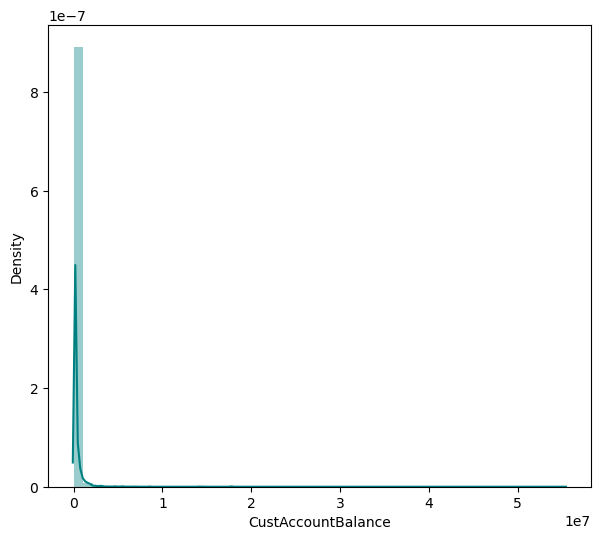


 
 Box Plot of CustAccountBalance:


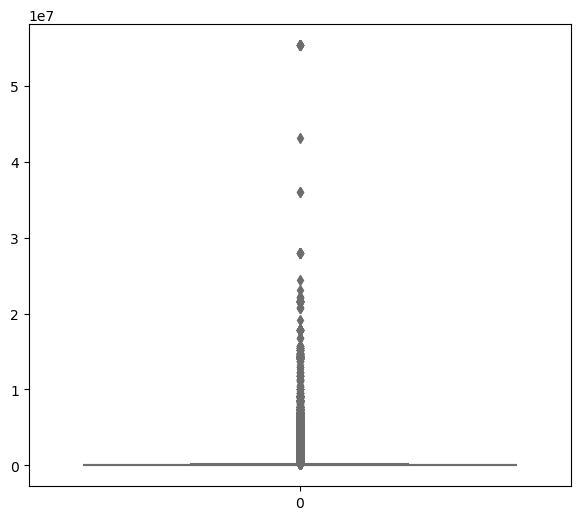

Quantile-Quantile Plot of CustAccountBalance:
Skewness of TransactionAmount (INR): 58.062896472827624
Kurtosis of TransactionAmount (INR): 9855.486815934657

 
 Distribution Plot of TransactionAmount (INR): 


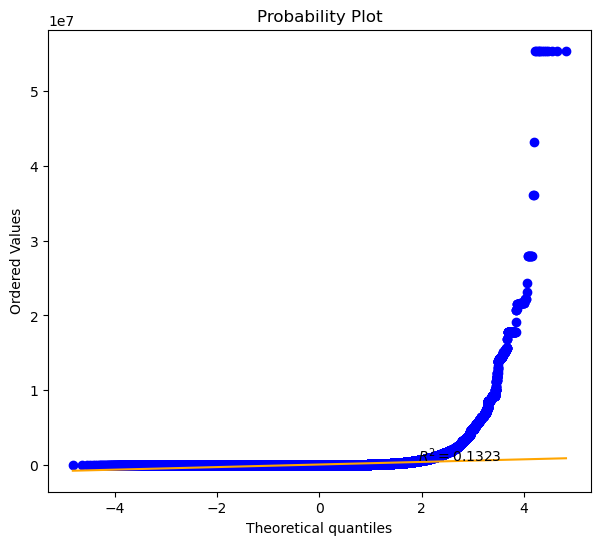

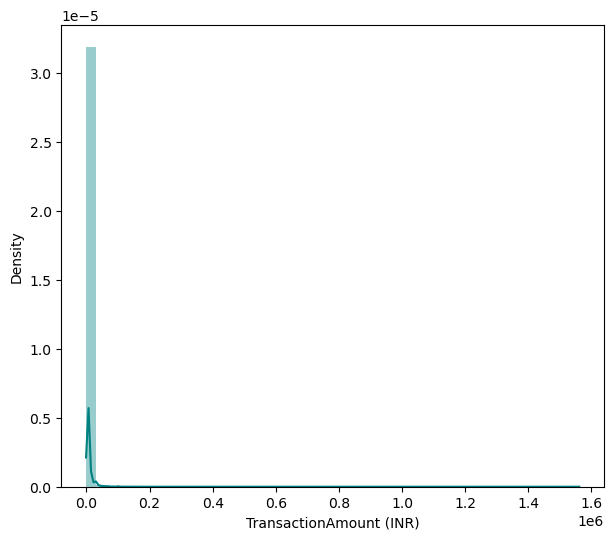


 
 Box Plot of TransactionAmount (INR):


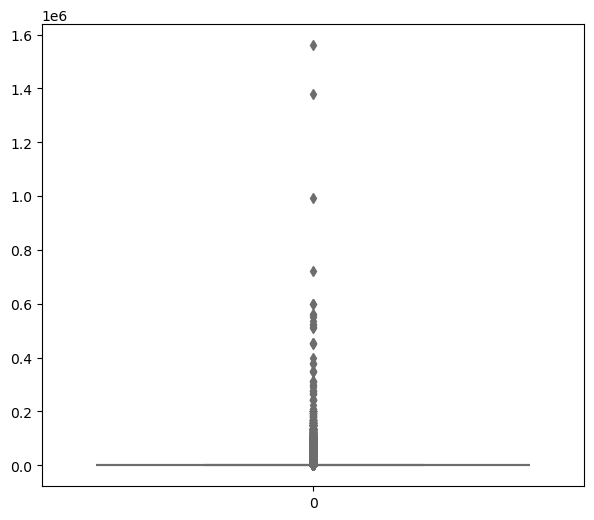

Quantile-Quantile Plot of TransactionAmount (INR):


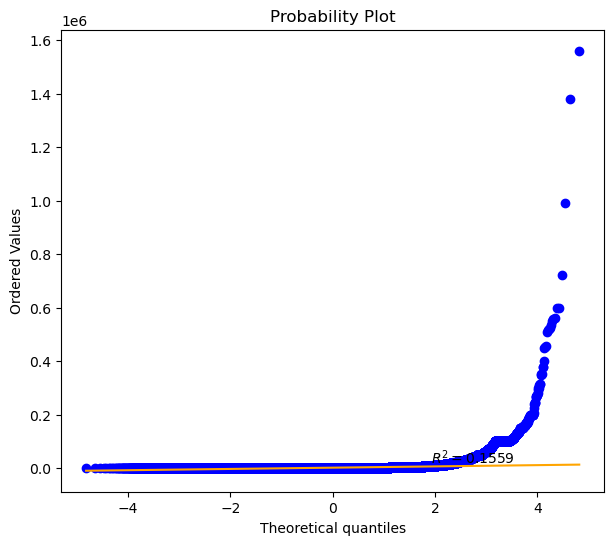

In [974]:

# Assuming df is your DataFrame
for col in df.columns:
    if df[col].dtype == np.float64:
        print("Skewness of {}:".format(col), df[col].skew())
        print("Kurtosis of {}:".format(col), df[col].kurt())

        # Distribution Plot
        plt.figure(figsize=(7,6))
        print("\n \n Distribution Plot of {}: ".format(col))
        sns.distplot(df[col], color='teal')  # Changed color to 'teal'
        plt.show()

        # Box Plot
        print("\n \n Box Plot of {}:".format(col))
        plt.figure(figsize=(7,6))
        sns.boxplot(df[col], color='salmon')  # Changed color to 'salmon'
        plt.show()

        # Quantile-Quantile Plot
        print("Quantile-Quantile Plot of {}:".format(col))
        plt.figure(figsize=(7,6))
        probplot(df[col], plot=plt, rvalue=True)
        plt.gca().get_lines()[1].set_color('orange')  # Changed Q-Q plot line color to 'orange'

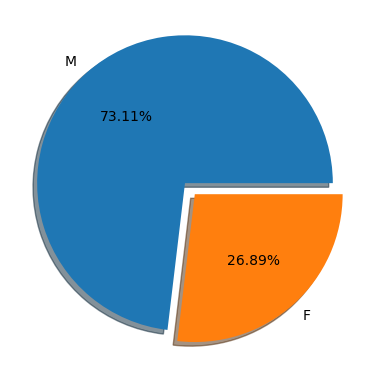

In [975]:
labels = df.CustGender.value_counts().keys()
values = df.CustGender.value_counts().values
explode = (0.1,0)

plt.pie(values,labels=labels,explode=explode,shadow=True,autopct='%1.2f%%');

A significant proportion of bank customers are males accounting for about 73% of the total share.

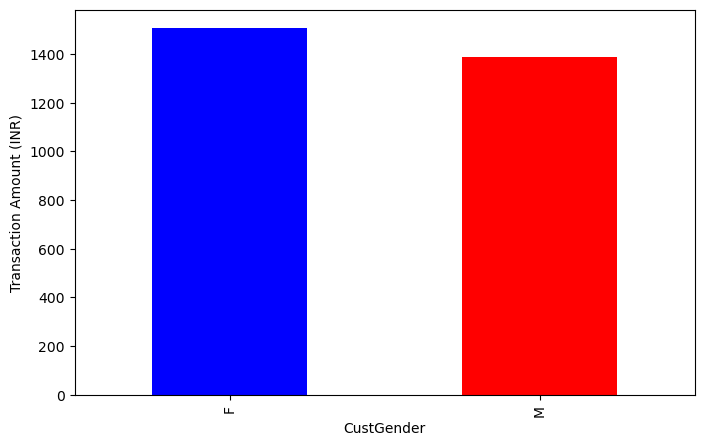

In [976]:
plt.figure(figsize=(8,5))
ax = df.groupby('CustGender')['TransactionAmount (INR)'].mean().plot(kind='bar',color=['blue','red'])
plt.ylabel('Transaction Amount (INR)');

At an average, females make slightly higher transactions than males.

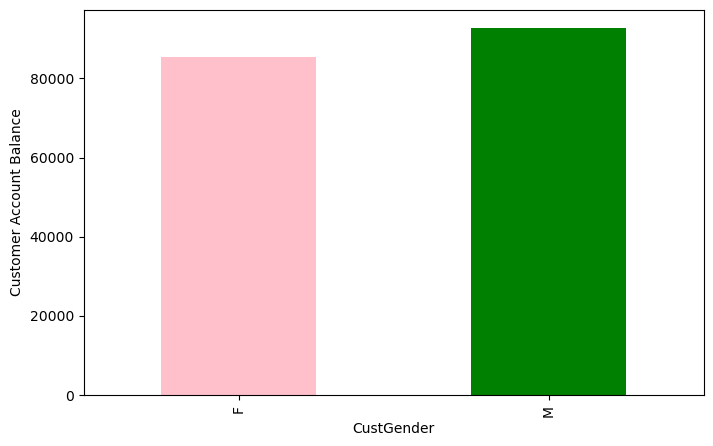

In [977]:
plt.figure(figsize=(8,5))
ax = df.groupby('CustGender')['CustAccountBalance'].mean().plot(kind='bar',color=['pink','green'])
plt.ylabel('Customer Account Balance');

At an average, male customers have marginally higher account balances in comparison to their female counterparts.

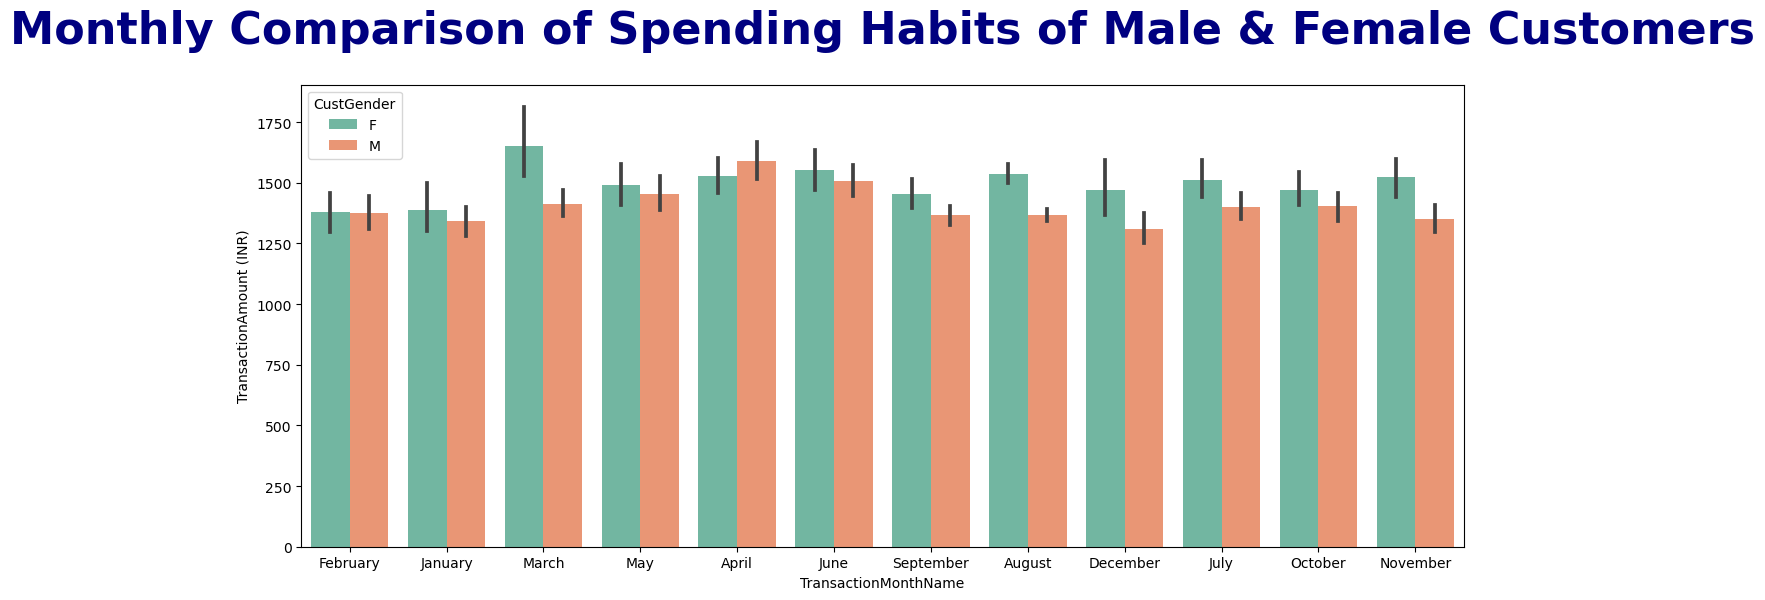

In [978]:
plt.figure(figsize=(15,6))
sns.barplot(data=df,x='TransactionMonthName',y='TransactionAmount (INR)',palette='Set2',hue='CustGender')
plt.title('Monthly Comparison of Spending Habits of Male & Female Customers',fontsize=32,fontweight='bold',color='navy',pad=30);

Male customers make higher transactions than their female counterparts only during the months of February and April. In all the remaining months, female customers perform greater transactions. Therefore, the bank must provide more special offers and incentives to female customers as they are likely to be substantially active in making larger transactions almost throughout the entire year.

Higher value transactions are mostly done during the months of March, April and June.

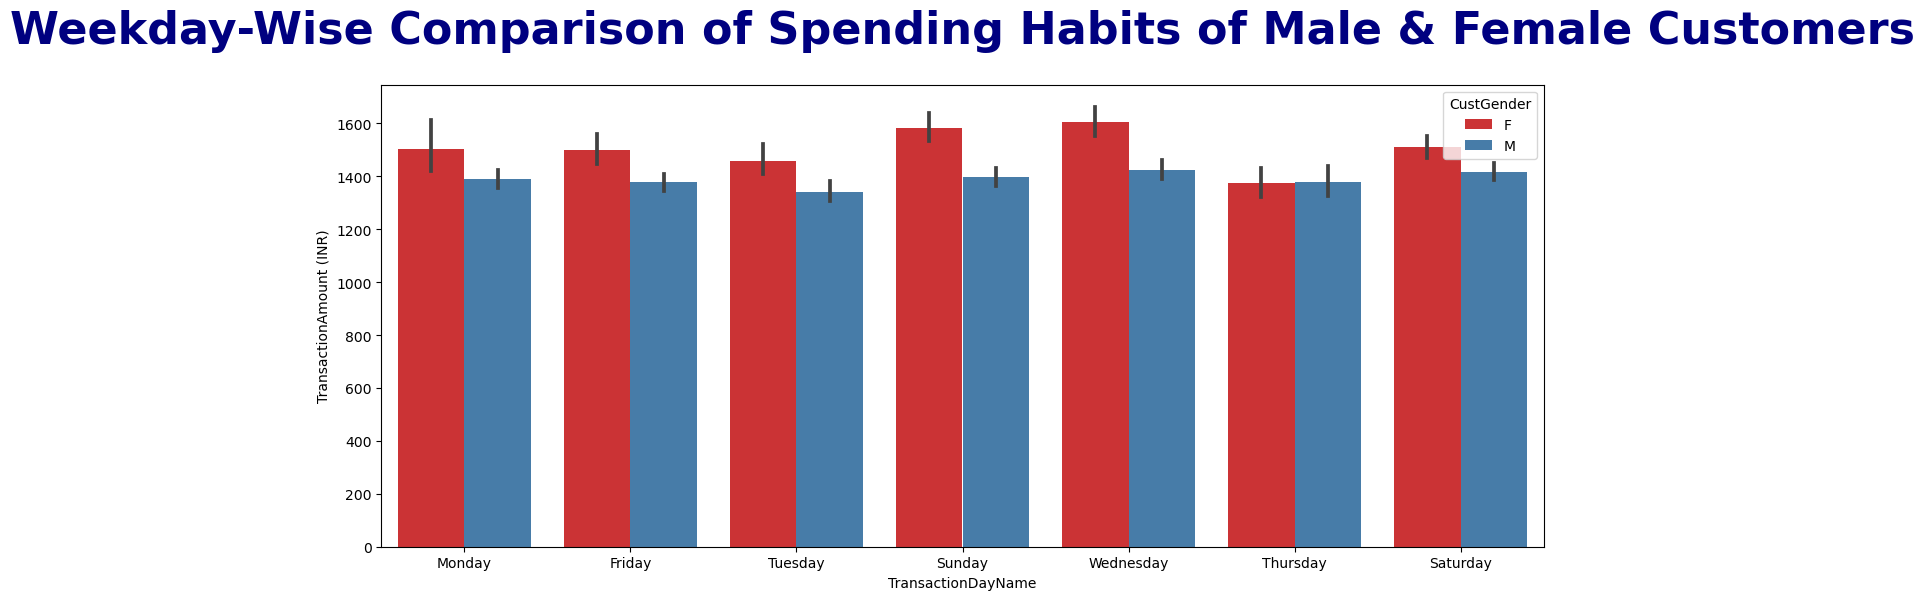

In [979]:
plt.figure(figsize=(15,6))
sns.barplot(data=df,x='TransactionDayName',y='TransactionAmount (INR)',palette='Set1',hue='CustGender')
plt.title('Weekday-Wise Comparison of Spending Habits of Male & Female Customers',fontsize=32,fontweight='bold',color='navy',pad=30);

Female customers perform higher transactions than their male counterparts in almost every week day.

Text(0.5, 1.0, 'Monthly Comparison of Account Balances of Male & Female Customers')

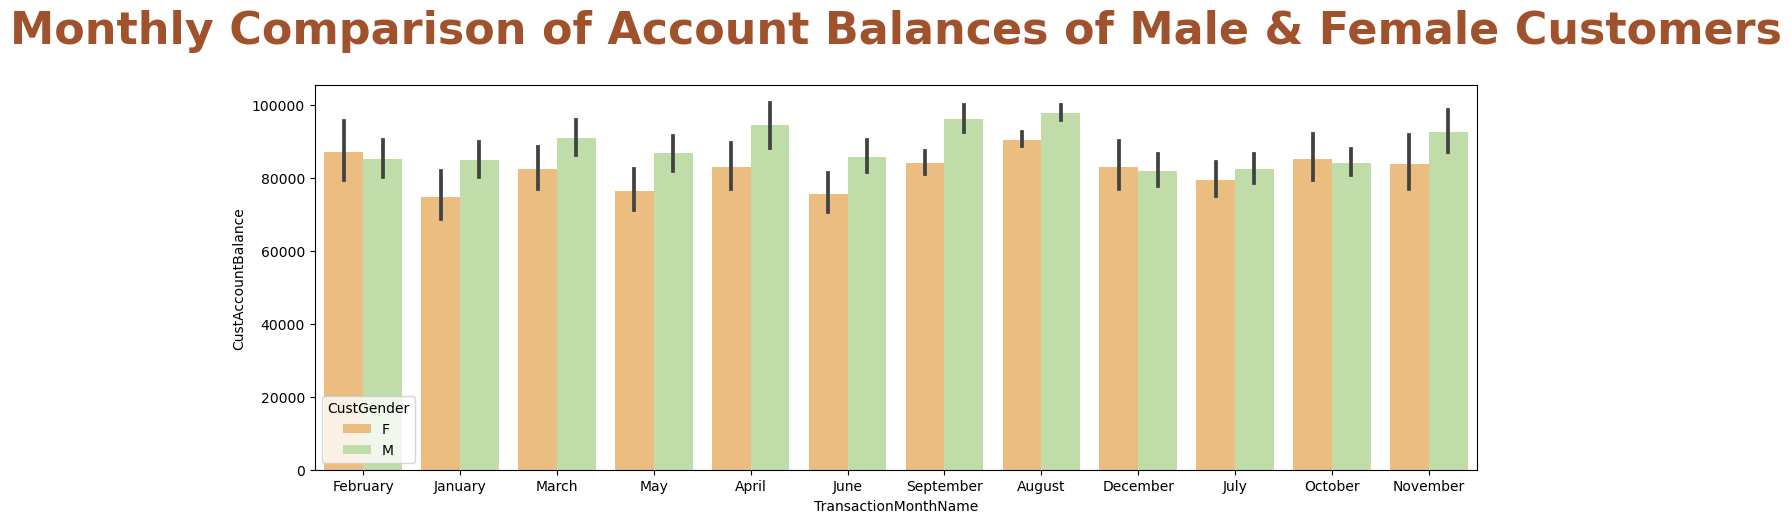

In [980]:
plt.figure(figsize=(15,5))
sns.barplot(data=df,x='TransactionMonthName',y='CustAccountBalance',palette='Spectral',hue='CustGender')
plt.title('Monthly Comparison of Account Balances of Male & Female Customers',fontsize=32,fontweight='bold',color='sienna',pad=30)


Male customers predominantly have greater account balances as compared to their female counterparts. This is evident from the fact that they generally make comparatively low value transactions than female customers.

<Axes: xlabel='TransactionMonthName', ylabel='TransactionAmount (INR)'>

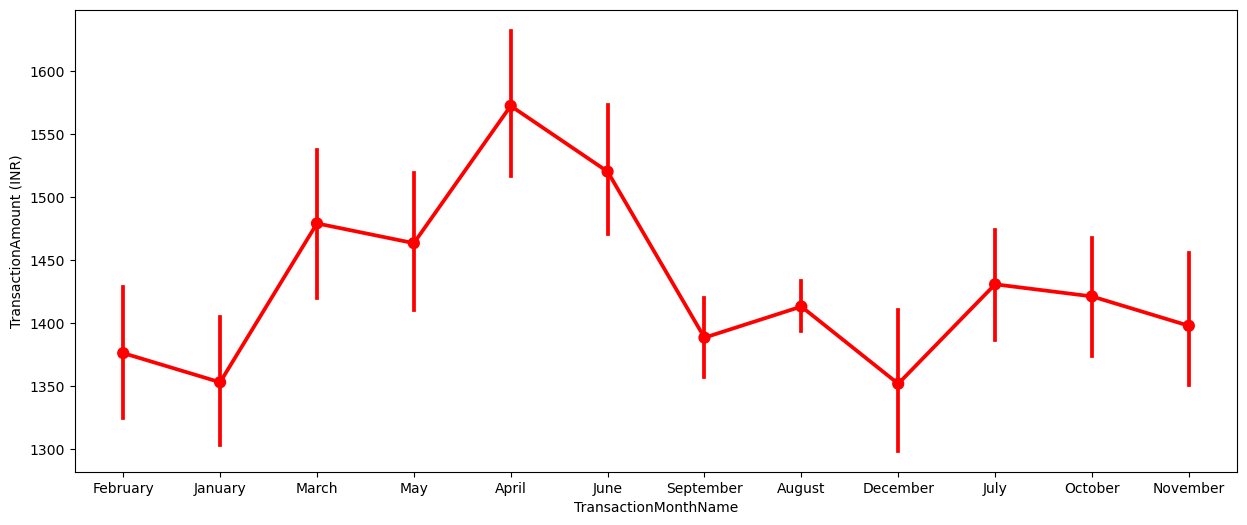

In [981]:
plt.figure(figsize=(15,6))
sns.pointplot(data=df,x='TransactionMonthName',y='TransactionAmount (INR)',color='red')

Highest value transactions are performed during the summer months while least value transactions are made in the winter months.

<Axes: xlabel='TransactionMonthName', ylabel='CustAccountBalance'>

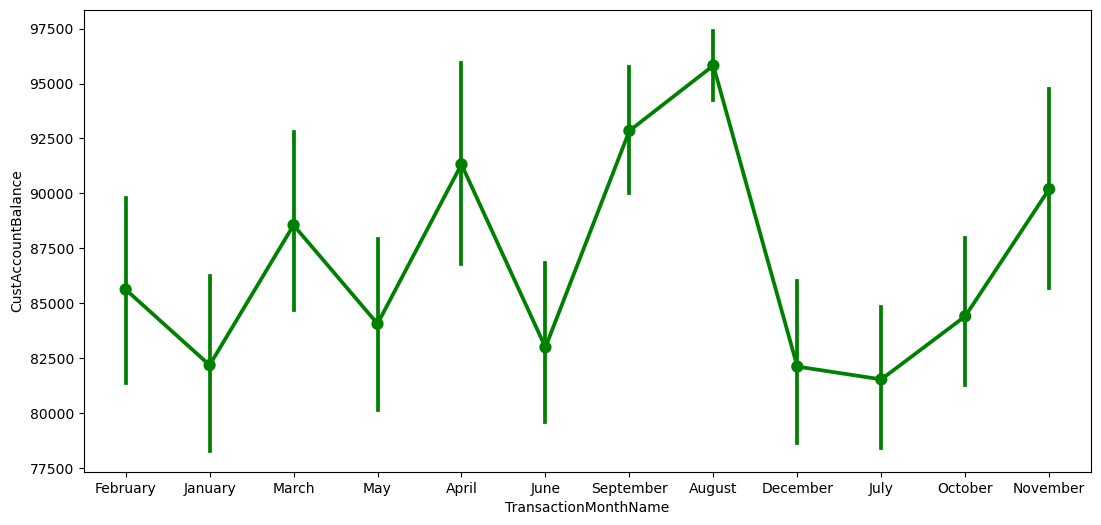

In [982]:
plt.figure(figsize=(13,6))
sns.pointplot(data=df,x='TransactionMonthName',y='CustAccountBalance',color='green')

Commonly, the account balances of customers are highest in the months of August and September whereas they are lowest in the months of July and December. In the festive months, the customer account balances drop significantly which makes sense as people usually expend more money during the festive season.

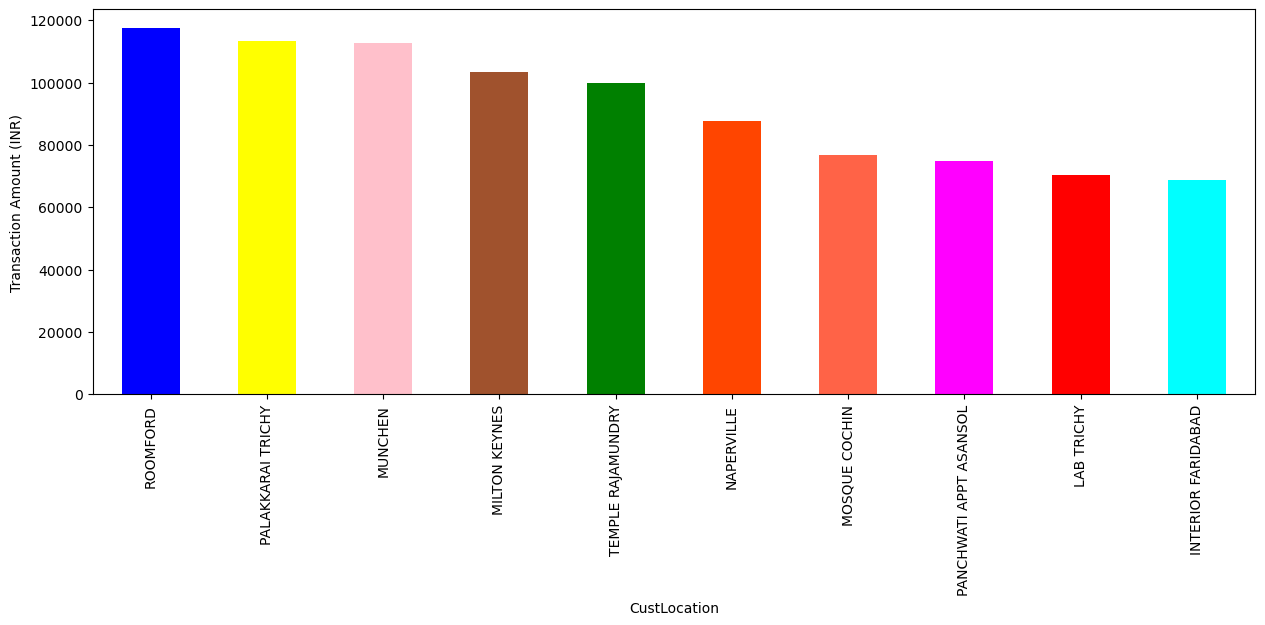

In [983]:
plt.figure(figsize=(15,5))
df.groupby('CustLocation')['TransactionAmount (INR)'].mean().sort_values(ascending=False)[:10].plot(kind='bar',color=['blue','yellow','pink','sienna','green','orangered','tomato','magenta','red','cyan'])
plt.ylabel('Transaction Amount (INR)');

Customers belonging to the Roomford bank branch in United Kingdom mostly perform the highest transactions which are closely followed by the bank branches in Palakkarai Trichy(Tamil Nadu, India) and Munchen in Germany.

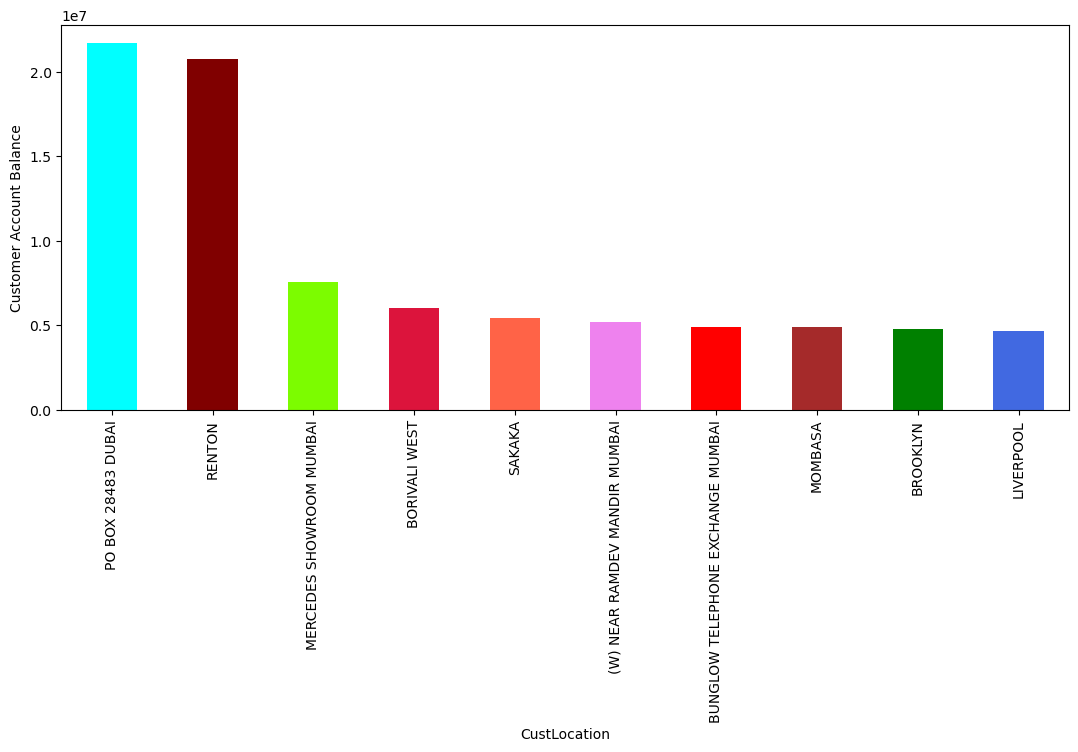

In [984]:
plt.figure(figsize=(13,5))
df.groupby('CustLocation')['CustAccountBalance'].mean().sort_values(ascending=False)[:10].plot(kind='bar',color=['aqua','maroon','lawngreen','crimson','tomato','violet','red','brown','green','royalblue'])
plt.ylabel('Customer Account Balance');

Customers living in PO Box 28483 Dubai bank branch have the highest account balances among all customers.

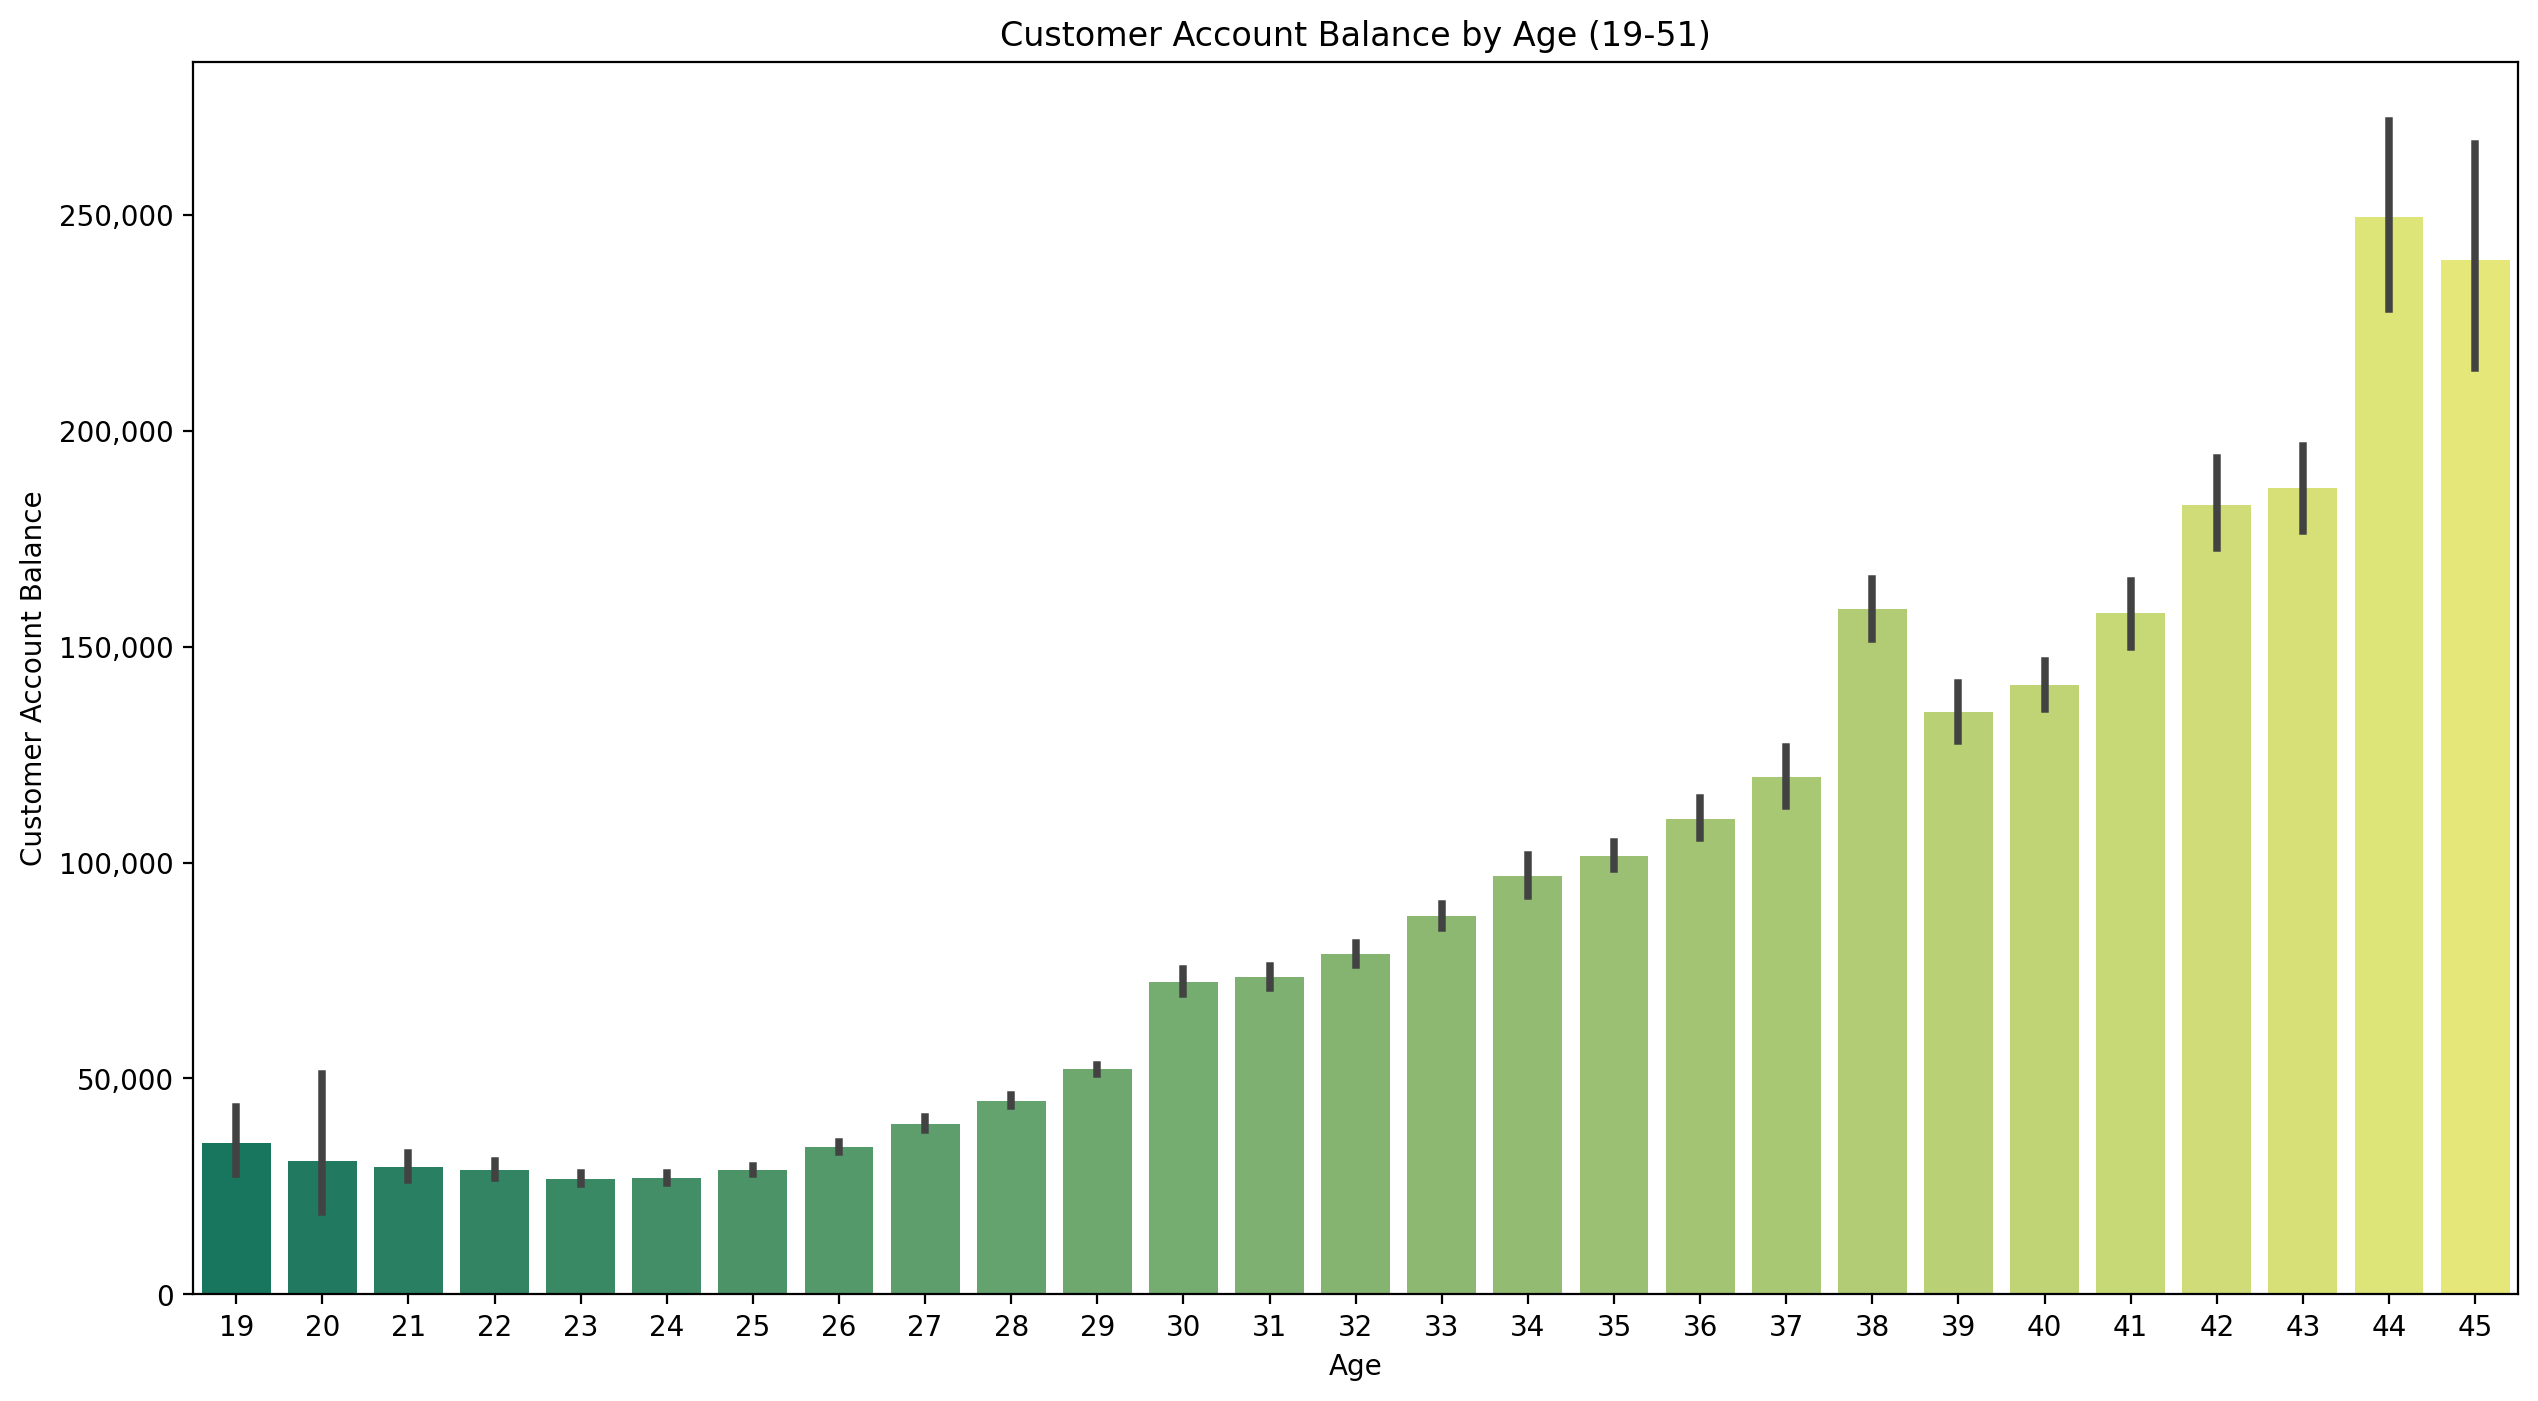

In [985]:

# Filter DataFrame for age between 19 and 50
filtered_df = df[(df['Age'] >= 19) & (df['Age'] <= 50)]

# Plotting
plt.figure(figsize=(15, 8), dpi=200)
sns.barplot(data=filtered_df, x='Age', y='CustAccountBalance', palette='summer')

# Set y-axis formatter to display full numbers
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.xlabel('Age')
plt.ylabel('Customer Account Balance')
plt.title('Customer Account Balance by Age (19-51)')
plt.show()

In general, the account balances of customers rise abruptly with increase in their ages.

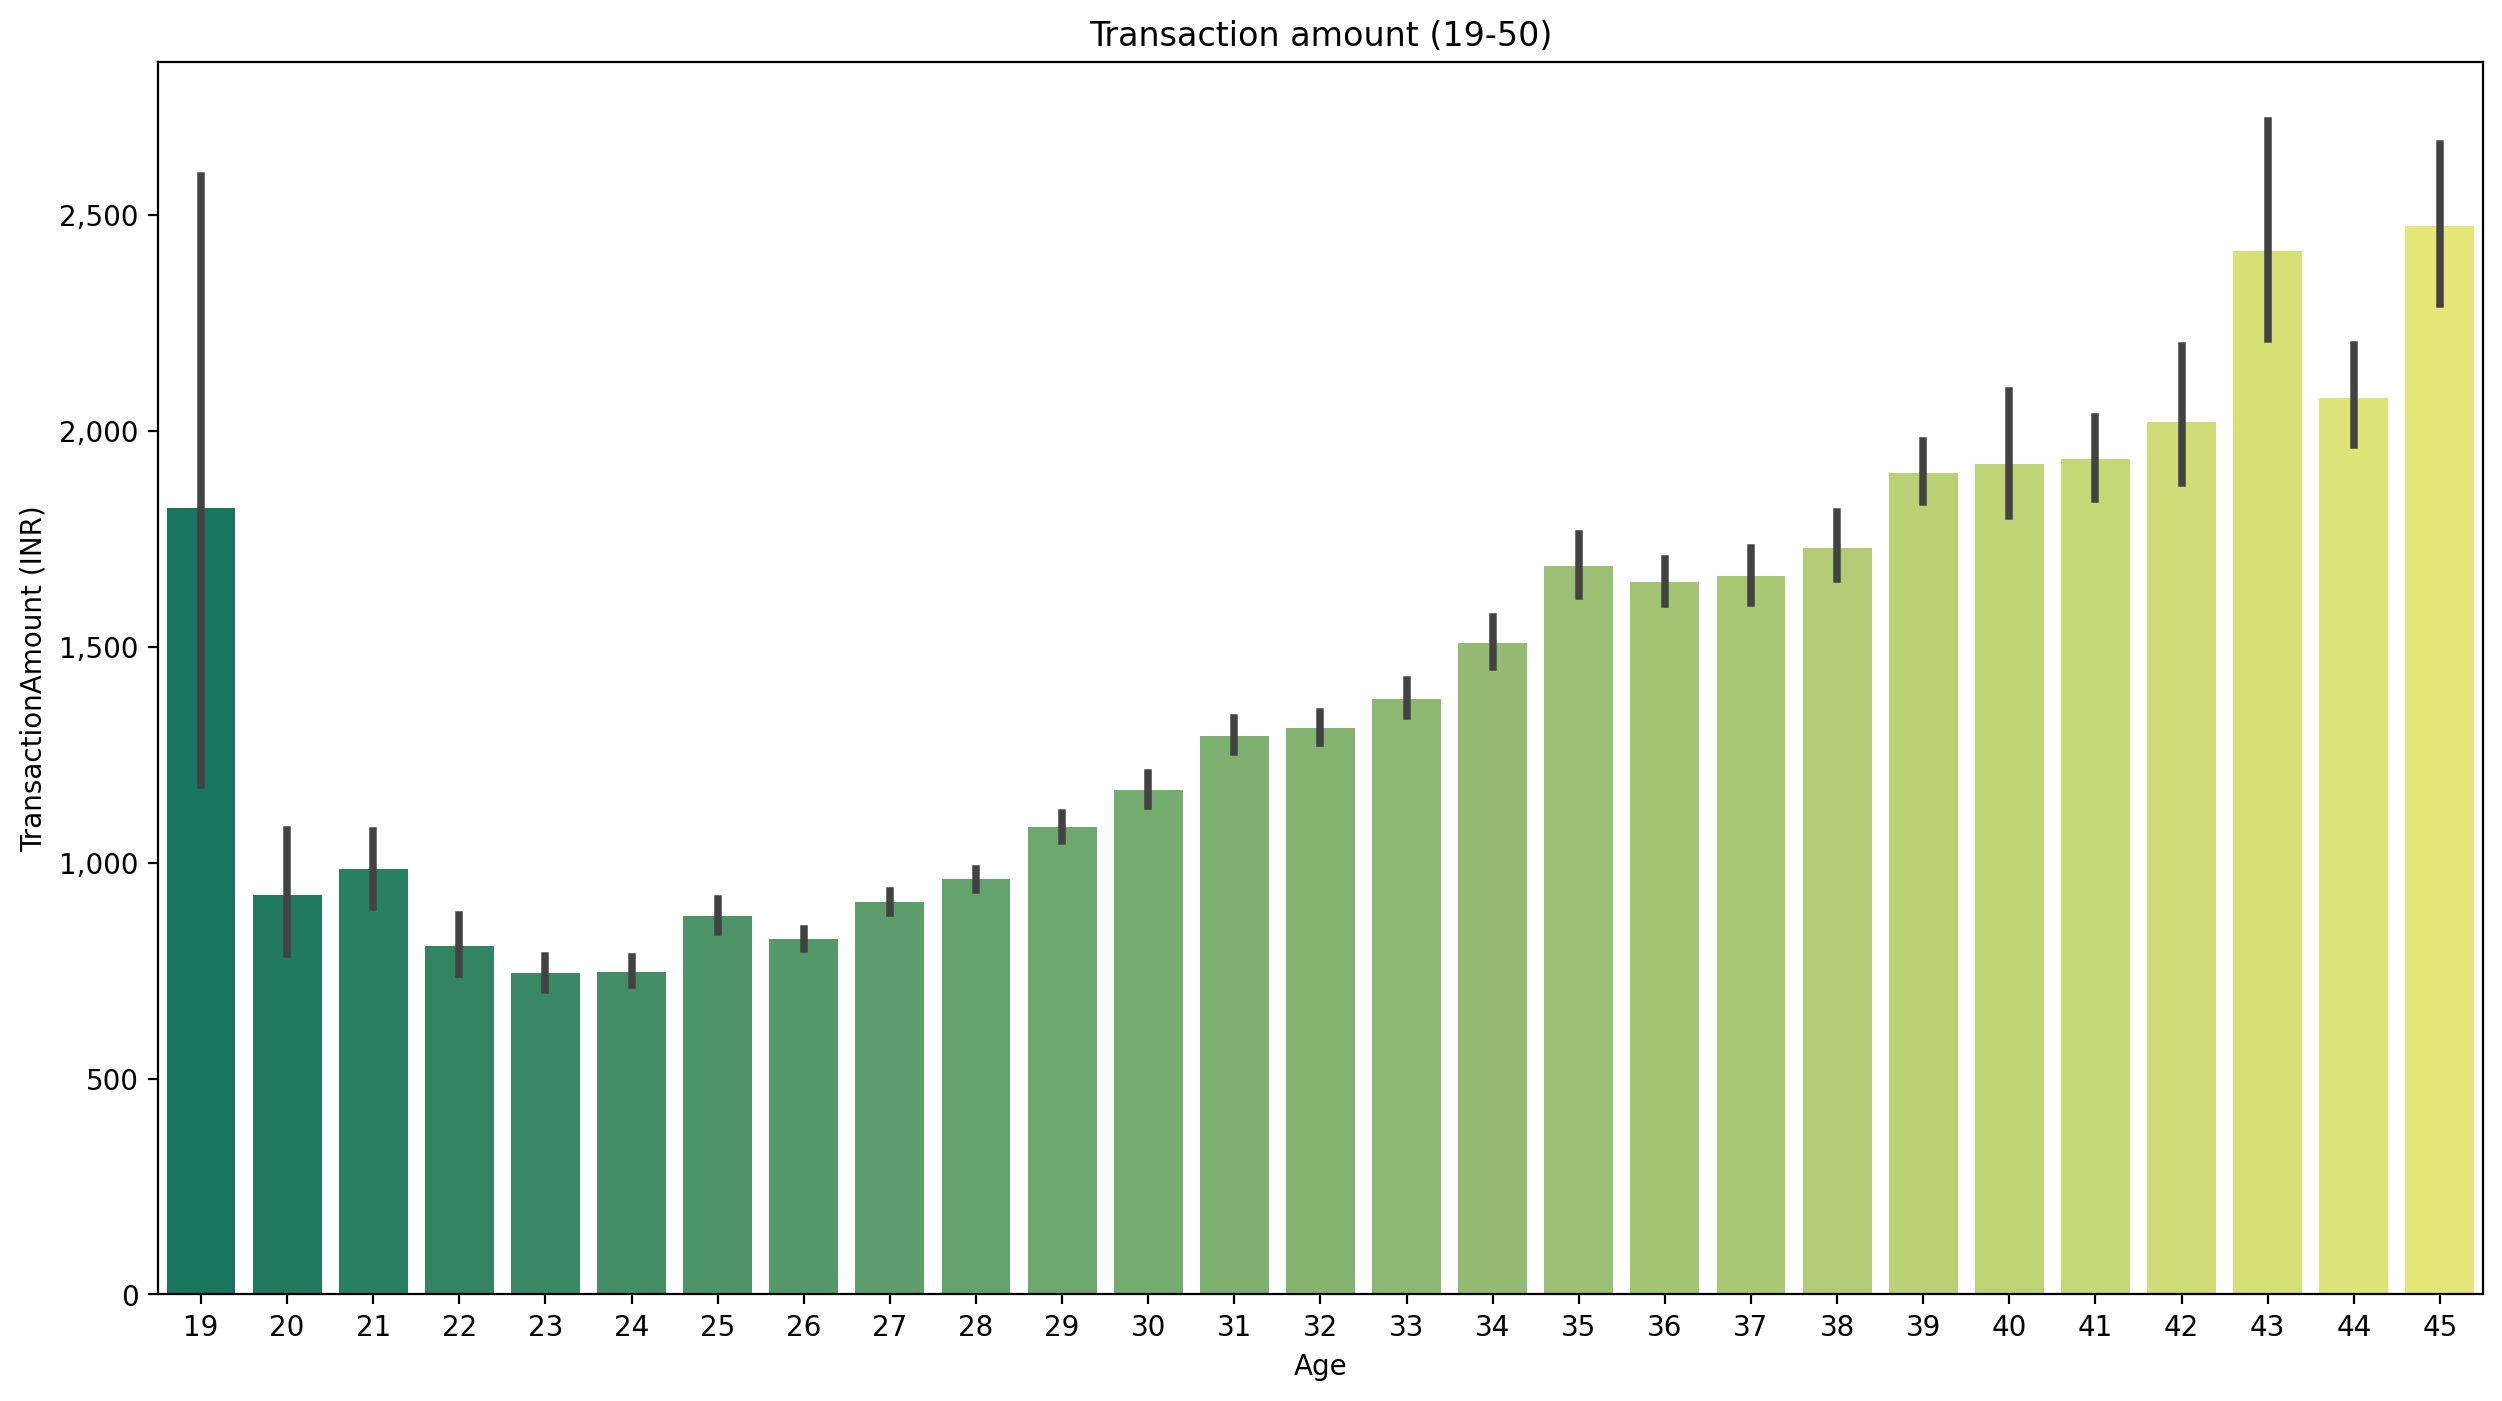

In [986]:

# Filter DataFrame for age between 19 and 48
filtered_df = df[(df['Age'] >= 19) & (df['Age'] <= 48)]

# Plotting
plt.figure(figsize=(15, 8), dpi=200)
sns.barplot(data=filtered_df, x='Age', y='TransactionAmount (INR)', palette='summer')

# Set y-axis formatter to display full numbers
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.xlabel('Age')
plt.ylabel('TransactionAmount (INR)')
plt.title('Transaction amount (19-50)')
plt.show()

Younger adult customers, in the age range of 19 to 24 years, perform exorbitant transactions as compared to their surrounding age groups. This is most probably due to the reason that younger adults between the ages of 18 to 24 years have their own career aspirations to fulfil as a consequence of which they generally have lavish and extravagant demands for fulfilling their passions and interests and for facilitating their development through all means. Nevertheless, middle age senior adults and elderly customers make comparatively more extortionate transactions for managing their families and livelihoods.

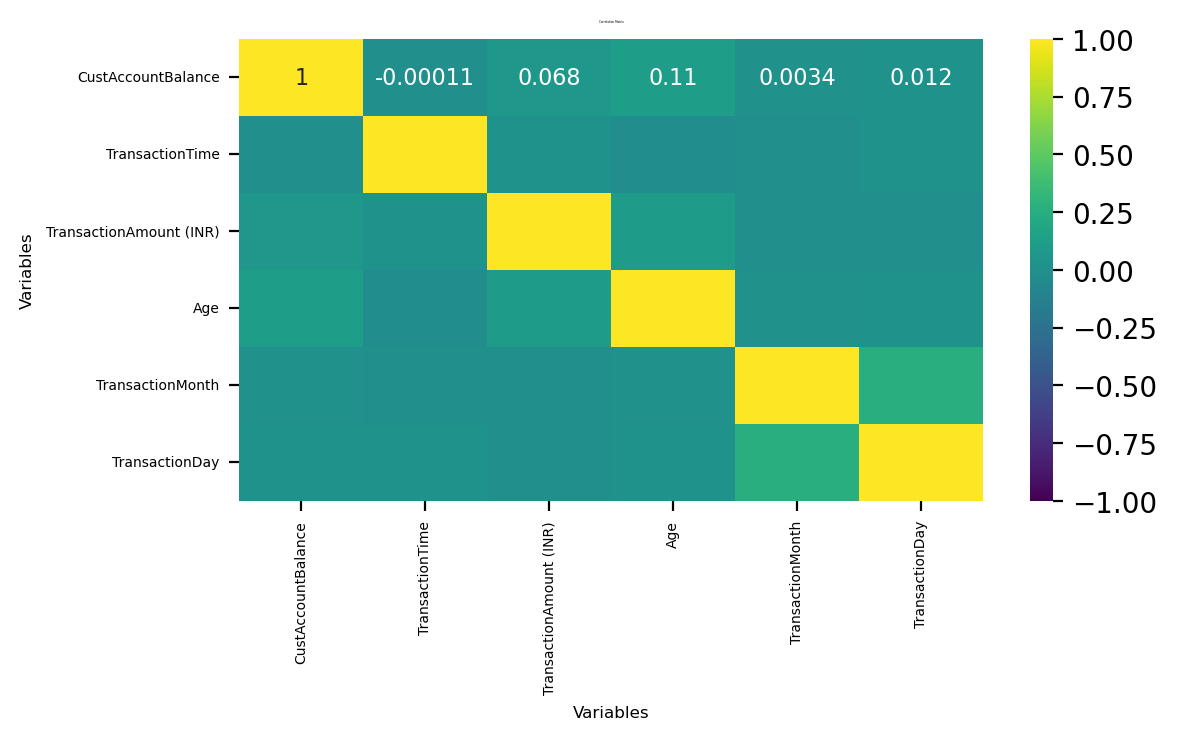

In [987]:
# Convert or drop non-numeric columns
df_numeric = df.select_dtypes(include=[float, int])



# Compute correlation matrix
corr_matrix = df_numeric.corr()

# Plot heatmap with reduced text size
plt.figure(figsize=(6, 3), dpi=200)
ax = sns.heatmap(corr_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1, annot_kws={"size": 8})

# Reduce text size for axis labels and title
ax.set_xlabel('Variables', fontsize=6)
ax.set_ylabel('Variables', fontsize=6)
ax.set_title('Correlation Matrix', fontsize=0)

# Adjust tick label size
ax.tick_params(axis='both', which='major', labelsize=5)


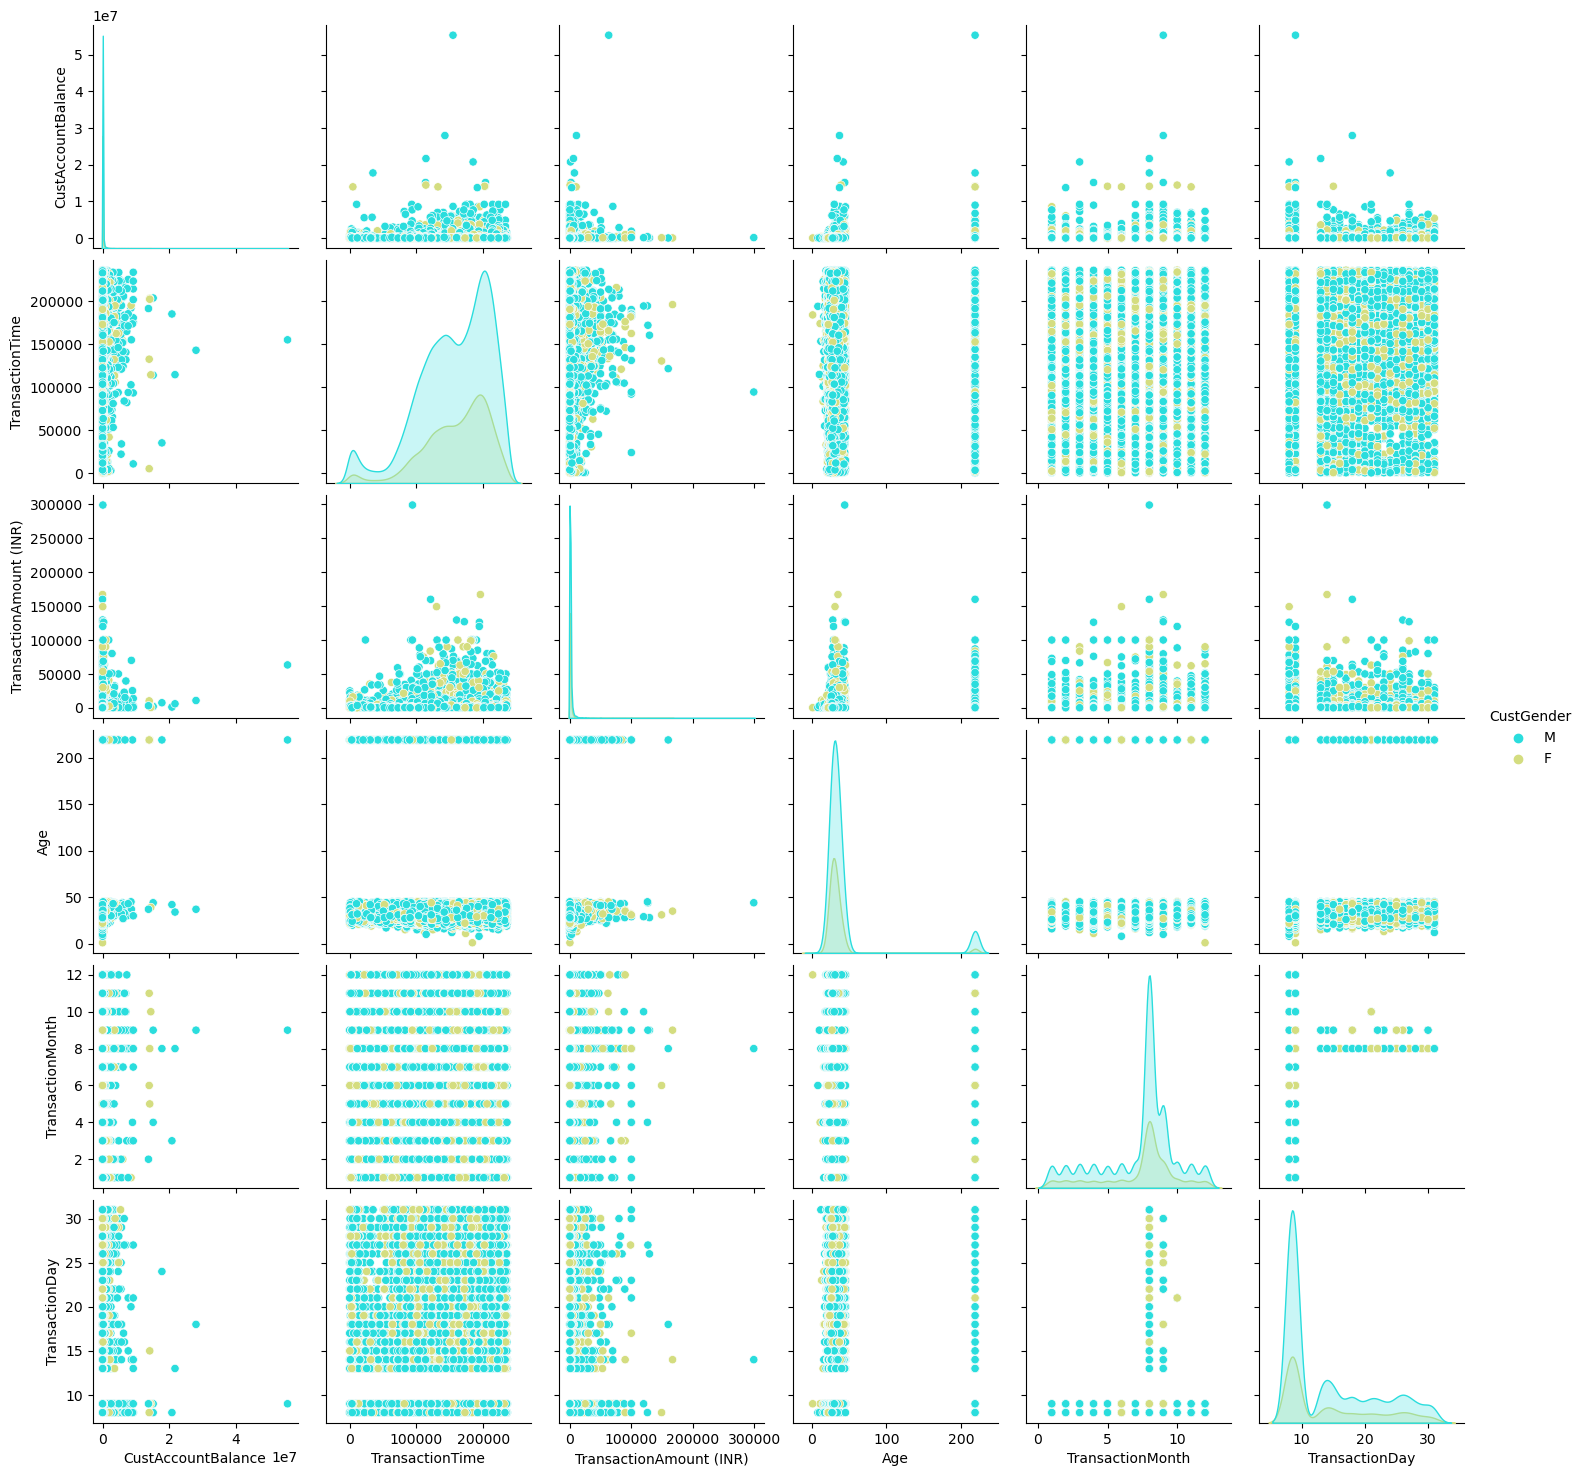

In [988]:
sns.pairplot(df.sample(n=50000),hue='CustGender',palette='rainbow')

## Feature Engineering Continued

In [989]:
df.CustGender.replace(['F','M'],[0,1],inplace=True)
df.CustGender = df.CustGender.astype(np.int64)

## Categorical Encoding

In [990]:
encoder = LabelEncoder()
df.CustLocation = encoder.fit_transform(df.CustLocation)
df.CustLocation = df.CustLocation.astype(np.int64)

In [991]:
df.drop(['TransactionMonthName','TransactionDayName'],axis=1,inplace=True)

## Feature Scaling

In [992]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df,columns=df.columns)
scaled_df.head()

,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),Age,TransactionMonth,TransactionDay
0,-1.648895,-0.224588,-0.153541,-0.272180,-0.232534,-0.414329,-2.026858,-0.879171
1,-1.648895,0.479465,-0.153425,-0.281764,-0.160221,-0.459101,-2.026858,-0.879171
2,-1.648895,0.643293,-0.176917,0.462621,0.056967,-0.257626,-2.026858,-0.879171
3,-1.648895,0.479465,-0.189002,0.320304,-0.142393,-0.347171,-2.026858,-0.879171
4,0.606467,0.479465,0.009088,0.257007,-0.212040,-0.123310,-2.026858,-0.879171


# Unsupervised Machine Learning

In [1001]:
temp = scaled_df.sample(n=10000)

## K Means Clustering

In [1002]:
base_kmeans = KMeans(random_state=101)
base_kmeans.fit(temp)

KMeans(random_state=101)

In [1003]:
labels = set(base_kmeans.labels_)
labels

{0, 1, 2, 3, 4, 5, 6, 7}

In [1004]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,base_kmeans.labels_)*100,2)) + '%')

Silhouette Score: 22.14%


In [1005]:
from sklearn.cluster import KMeans
import numpy as np


for i in range(1, 11):
    for init in ['k-means++', 'random']:
        for algo in ['lloyd', 'elkan']:  # Use 'lloyd' and 'elkan' as valid options
            kmeans = KMeans(n_clusters=i, init=init, algorithm=algo, random_state=101)
            kmeans.fit(temp)
            print("Number of Clusters: {}".format(i))
            print("Initialization Algorithm: {}".format(init))
            print("Algorithm: {}".format(algo))
            print("Sum of Squared Distance: %d" % kmeans.inertia_)
            print('-----------------')


Number of Clusters: 1
Initialization Algorithm: k-means++
Algorithm: lloyd
Sum of Squared Distance: 92625
-----------------
Number of Clusters: 1
Initialization Algorithm: k-means++
Algorithm: elkan
Sum of Squared Distance: 92625
-----------------
Number of Clusters: 1
Initialization Algorithm: random
Algorithm: lloyd
Sum of Squared Distance: 92625
-----------------
Number of Clusters: 1
Initialization Algorithm: random
Algorithm: elkan
Sum of Squared Distance: 92625
-----------------
Number of Clusters: 2
Initialization Algorithm: k-means++
Algorithm: lloyd
Sum of Squared Distance: 83083
-----------------
Number of Clusters: 2
Initialization Algorithm: k-means++
Algorithm: elkan
Sum of Squared Distance: 83083
-----------------
Number of Clusters: 2
Initialization Algorithm: random
Algorithm: lloyd
Sum of Squared Distance: 82369
-----------------
Number of Clusters: 2
Initialization Algorithm: random
Algorithm: elkan
Sum of Squared Distance: 82369
-----------------
Number of Clusters: 

In [1006]:
optimized_kmeans = KMeans(n_clusters=10,init='k-means++',algorithm='elkan',random_state=101)
optimized_kmeans.fit(temp)
print("Silhouette Score:",str(np.round(silhouette_score(temp,optimized_kmeans.labels_)*100,2)) + '%')

Silhouette Score: 22.6%


In [1007]:
print("Estimated number of clusters:", len(set(optimized_kmeans.labels_)), set(optimized_kmeans.labels_))
print("Estimated number of noise points:", list(optimized_kmeans.labels_).count(-1))

Estimated number of clusters: 10 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Estimated number of noise points: 0


<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

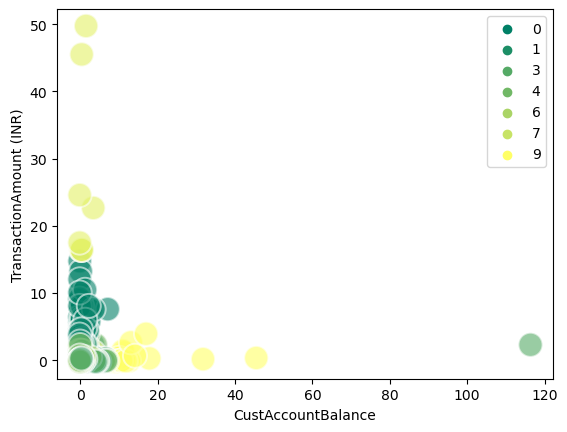

In [1008]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount (INR)',hue=optimized_kmeans.labels_,s=300,alpha=0.6,palette='summer')


In [1011]:
ce = clusteval(cluster='kmeans',savemem=True,verbose=4)
results = ce.fit(np.reshape(np.ravel(temp.sample(1000)),(-1,1)))
cluster_labels = results['labx']

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO> Save memory enabled for kmeans with evaluation silhouette.
[clusteval] >INFO: 100%|███████████████████████████████████████████████████████████████| 23/23 [00:23<00:00,  1.00s/it]
[clusteval] >DEBUG> [[ 1  1  0 ...  0  1  1]
 [ 2  2  1 ...  1  1  2]
 [ 2  2  1 ...  1  2  2]
 ...
 [ 1 17  0 ... 12  7  1]
 [ 0  0  5 ...  7 11  0]
 [23  1  3 ... 21 10 23]]
[clusteval] >DEBUG> Iloc: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
[clusteval] >DEBUG> silscores: [0.55497934 0.57887411 0.60828663 0.61009287 0.66089087 0.63940798
 0.65058138 0.63999763 0.6306503  0.6522954  0.59820176 0.63912997
 0.66113092 0.62542786 0.64375098 0.63051288 0.63764263 0.63260965
 0.58743461 0.63284281 0.65345576 0.6443759  0.66059172]
[c

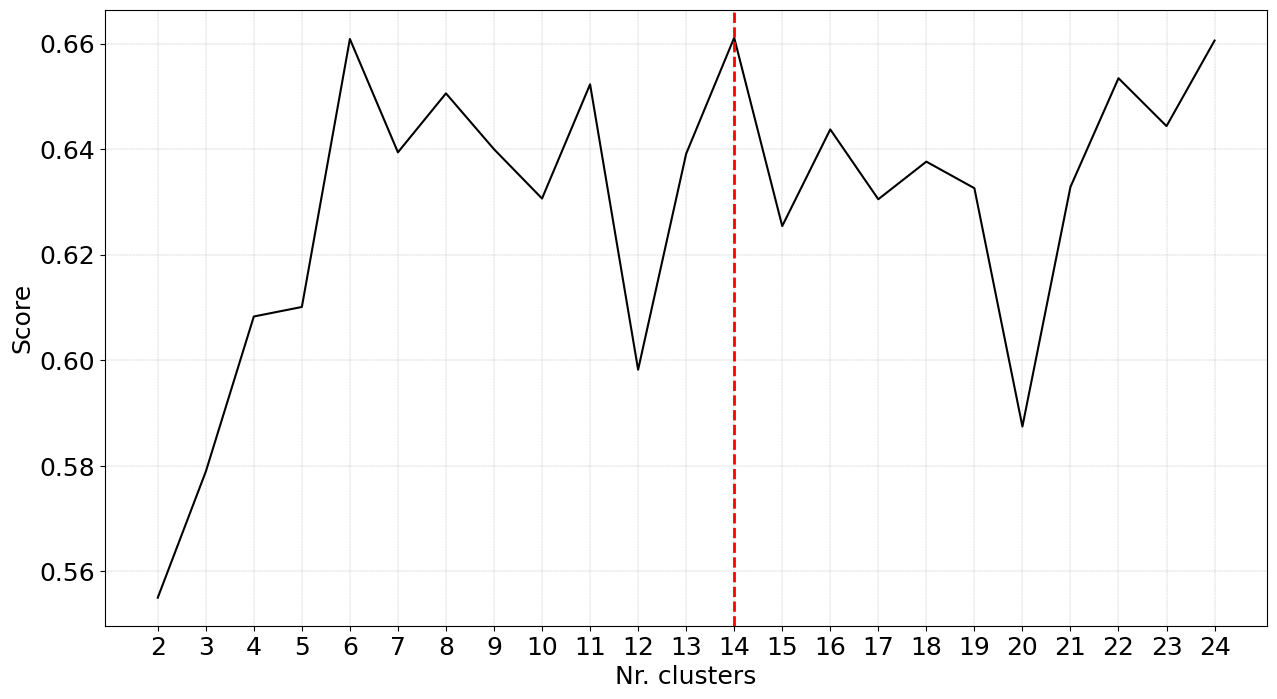

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [1012]:
ce.plot()

## Hierarchical Clustering

In [1013]:
mmscaler = MinMaxScaler()
minmax_scaled_df = mmscaler.fit_transform(df)
minmax_scaled_df = pd.DataFrame(minmax_scaled_df,columns=df.columns)
minmax_scaled_df.head()

,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),Age,TransactionMonth,TransactionDay
0,0.0,0.383554,0.000322,0.606915,0.000016,0.105505,0.090909,0.0
1,0.0,0.562967,0.000323,0.604817,0.000294,0.096330,0.090909,0.0
2,0.0,0.604715,0.000121,0.767744,0.001130,0.137615,0.090909,0.0
3,0.0,0.562967,0.000018,0.736594,0.000363,0.119266,0.090909,0.0
4,1.0,0.562967,0.001717,0.722740,0.000095,0.165138,0.090909,0.0


In [1018]:
temp2 = minmax_scaled_df.sample(n=5000)

In [1019]:
base_hc = AgglomerativeClustering()
base_hc.fit(temp2)

AgglomerativeClustering()

In [1021]:
print("Estimated number of clusters:", set(base_hc.labels_))

Estimated number of clusters: {0, 1}


In [1022]:
print("Estimated number of noise points:", list(base_hc.labels_).count(-1))

Estimated number of noise points: 0


In [1023]:
print("Silhouette Score:",str(np.round(silhouette_score(temp2,base_hc.labels_)*100,2)) + '%')

Silhouette Score: 41.49%


<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

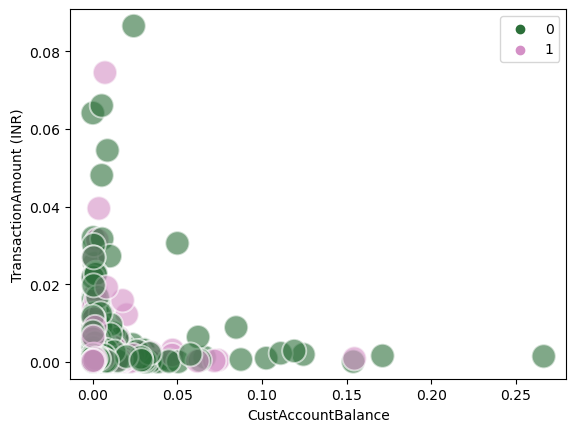

In [1024]:
sns.scatterplot(x=temp2['CustAccountBalance'], y=temp2['TransactionAmount (INR)'], hue=base_hc.labels_, s=300, alpha=0.6, palette='cubehelix')

In [1025]:
temp2_samp = temp2.sample(500)
ce = clusteval(verbose=4)
results = ce.fit(np.reshape(np.ravel(temp2_samp),(-1,1)))
results

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|███████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  3.86it/s]
[clusteval] >DEBUG> [[ 2  2  1 ...  1  2  2]
 [ 2  3  1 ...  1  3  3]
 [ 3  4  1 ...  2  4  4]
 ...
 [11 22  1 ...  3 20 18]
 [11 23  1 ...  3 20 18]
 [11 24  1 ...  3 21 18]]
[clusteval] >DEBUG> Iloc: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
[clusteval] >DEBUG> silscores: [0.75625969 0.73086686 0.7108024  0.685564   0.73646363 0.73924135
 0.75940578 0.74998987 0.75619673 0.7688884  0.75018615 0.76459646
 0.76517022 0.76692563 0.77296681 0.77385298 0.77968249 0.78641476
 0.79226473 0.78991618 0.79655445 0.8020048  0.80384671]
[clusteval] >DEBUG> sillclust: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 1

{'evaluate': 'silhouette',
 'score':     cluster_threshold  clusters     score
 0                   2         2  0.756260
 1                   3         3  0.730867
 2                   4         4  0.710802
 3                   5         5  0.685564
 4                   6         6  0.736464
 5                   7         7  0.739241
 6                   8         8  0.759406
 7                   9         9  0.749990
 8                  10        10  0.756197
 9                  11        11  0.768888
 10                 12        12  0.750186
 11                 13        13  0.764596
 12                 14        14  0.765170
 13                 15        15  0.766926
 14                 16        16  0.772967
 15                 17        17  0.773853
 16                 18        18  0.779682
 17                 19        19  0.786415
 18                 20        20  0.792265
 19                 21        21  0.789916
 20                 22        22  0.796554
 21               

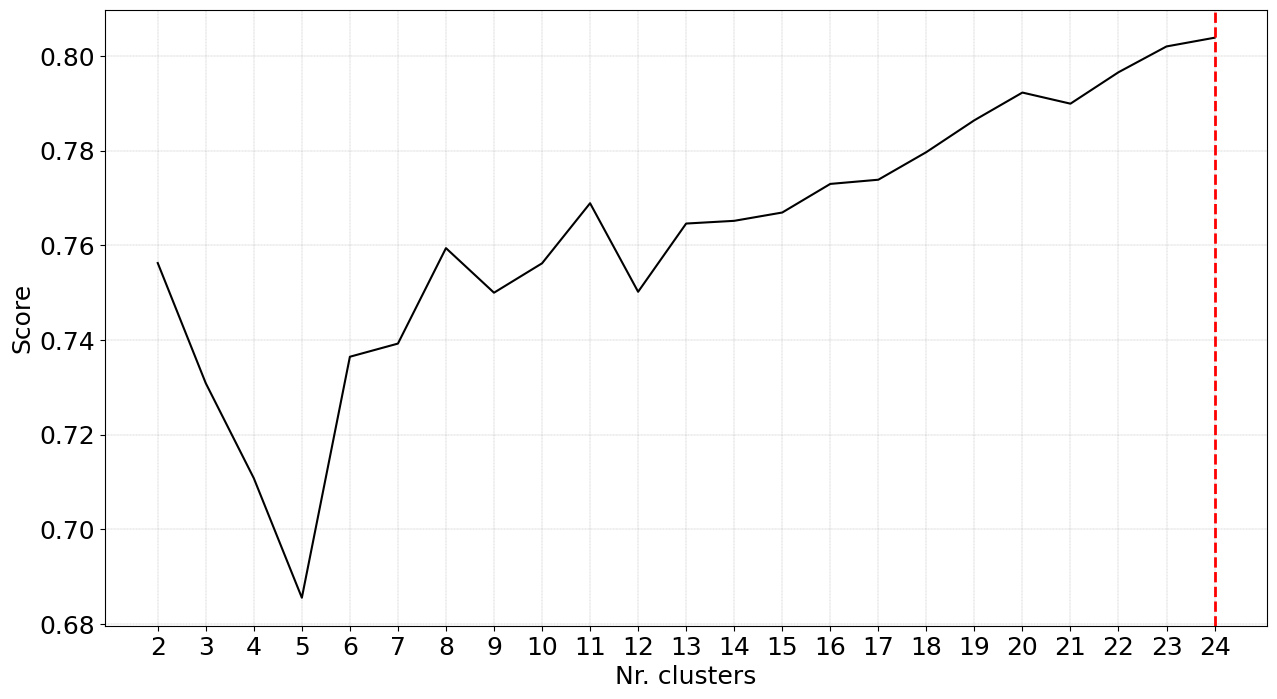

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [1026]:
ce.plot()

## Density-based Spatial Clustering with Applications with Noise(DBSCAN)

In [1027]:
base_dbscan = DBSCAN()
base_dbscan.fit(temp)

DBSCAN()

In [1028]:
print("Estimated number of clusters:", set(base_dbscan.labels_))

Estimated number of clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, -1}


In [1029]:
print("Estimated number of noise points:", list(base_dbscan.labels_).count(-1))

Estimated number of noise points: 1801


In [1030]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,base_dbscan.labels_)*100,2)) + '%')

MemoryError: Unable to allocate 763. MiB for an array with shape (10000, 10000) and data type float64

In [ ]:
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):
    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances[:,k-1], axis=0)
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.show()
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    knee.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.show()
    return distances[knee.knee]

In [ ]:
k = 2 * temp.shape[-1]
x = get_kdist_plot(temp,k)
print("Knee Point:",x)

In [ ]:
ms = np.arange(3,2*temp.shape[1],3)
silhouette_scores = []

for i in ms:
    dbscan = DBSCAN(eps=x,min_samples=i)
    dbscan.fit(temp)
    silhouette_scores.append(silhouette_score(temp,dbscan.labels_))
    print("{} Minimum Samples Tested!".format(i))

In [ ]:
plt.figure(figsize=(8, 3), dpi=150)
sns.lineplot(x=ms, y=silhouette_scores)
plt.xlabel('Minimum Number of Samples')
plt.ylabel('Silhouette Score')
plt.show()


In [ ]:
optimized_dbscan = DBSCAN(eps=x,min_samples=11)
optimized_dbscan.fit(temp)

In [ ]:
print("Estimated number of clusters:",set(optimized_dbscan.labels_))

In [ ]:
print("Estimated number of noise points:",list(optimized_dbscan.labels_).count(-1))

In [ ]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,optimized_dbscan.labels_)*100,2)) + '%')

In [ ]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount (INR)',hue=optimized_dbscan.labels_,s=300,alpha=0.6,palette='coolwarm')

In [ ]:
temp['Cluster'] = optimized_dbscan.labels_

In [ ]:
temp.groupby('Cluster')[['CustAccountBalance','TransactionAmount (INR)']].mean().plot(kind='bar')

## Determination of Optimum Epsilon Value for DBSCAN Model

In [ ]:
temp = temp.sample(500)
ce = clusteval(cluster='dbscan',verbose=3)
results = ce.fit(np.reshape(np.ravel(temp),(-1,1)))
results

In [ ]:
cluster_labels = results['labx']
cluster_labels

In [ ]:
print("Distinct Cluster Labels Detected:",np.unique(cluster_labels))

In [ ]:
ce.plot()

In [ ]:
enhanced_dbscan = DBSCAN(eps=3,min_samples=2*temp.shape[1])
enhanced_dbscan.fit(temp)

In [ ]:
print("Estimated number of clusters:",len(set(enhanced_dbscan.labels_)),set(enhanced_dbscan.labels_))

In [ ]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount (INR)',hue=enhanced_dbscan.labels_,palette='prism',s=300,alpha=0.5)

In [ ]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,enhanced_dbscan.labels_)*100,2)) + '%')

The optimized DBSCAN model has classified the entire population of customers primarily into two major groups, one of them consists of all those customers who have modest account balance and make low-value transactions whereas the miscellaneous group includes either the customers who have high account balances and spend very less money through transactions or those who have minimal account balance but expend a large amount of cash through high-value transactions.

## Principal Component Analysis(PCA)

In [ ]:
temp = scaled_df.sample(10000)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(temp)
pca_components = pd.DataFrame(pca_components,columns=['PC1','PC2'])
pca_components.head()

In [ ]:
base_spectral = SpectralClustering(random_state=101)

In [ ]:
base_spectral.fit(pca_components)

In [ ]:
print("Estimated number of clusters:",len(set(base_spectral.labels_)))
print("Clusters:",set(base_spectral.labels_))

In [ ]:
pca_components['Cluster'] = base_spectral.labels_
print("Silhouette Score:",str(np.round(silhouette_score(pca_components,pca_components.Cluster)*100,2)) + '%')

In [ ]:
sns.scatterplot(x=pca_components['PC1'], y=pca_components['PC2'], hue=pca_components['Cluster'], palette='plasma')


In [ ]:
pca_components.groupby('Cluster')[['PC1','PC2']].mean().plot(kind='bar',color=['grey','magenta'])

### On Original Feature Space

In [ ]:
temp = scaled_df.sample(n=10000)

In [ ]:
base_spectral = SpectralClustering(random_state=101)
base_spectral.fit(temp)

In [ ]:
print("Estimated number of clusters:",set(base_spectral.labels_))

In [ ]:
print("Estimated number of noise points:",list(base_spectral.labels_).count(-1))

In [ ]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,base_spectral.labels_)*100,2)) + '%')

In [ ]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount (INR)',hue=base_spectral.labels_,s=300,alpha=0.8,palette='Set1')

The Spectral clustering algorithm has segregated the customers into two distinct groups. The first group comprises the dynamic customers who have lower account balance and mostly expend less cash on transactions barring a few who perform large-value transactions whereas the second group includes the more conservative and money saving-minded people who, inspite of having really high account balances, spend the least amount of money in transactions, thereby judiciously maintaining their savings accounts.